In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [3]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [5]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [6]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [7]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [8]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [9]:
def build_1d_cnn_custom_DO_BN(conv_num=1):
    init_channel = 128
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel/(2**int((i+1)/4))), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [10]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 128)        512       
_________________________________________________________________
activation (Activation)      (None, 16000, 128)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2048000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2048000)           0         
_________________________________________________________________
dense (Dense)        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_11 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5333, 128)         0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_29 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5333, 128)         0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2730 - acc: 0.2958
Epoch 00001: val_loss improved from inf to 1.65314, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_DO_BN_6_conv_checkpoint/001-1.6531.hdf5
36805/36805 [==============================] - 186s 5ms/sample - loss: 2.2728 - acc: 0.2959 - val_loss: 1.6531 - val_acc: 0.4584
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4362 - acc: 0.5385
Epoch 00002: val_loss improved from 1.65314 to 1.01421, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_DO_BN_6_conv_checkpoint/002-1.0142.hdf5
36805/36805 [==============================] - 183s 5ms/sample - loss: 1.4362 - acc: 0.5385 - val_loss: 1.0142 - val_acc: 0.7023
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1318 - acc: 0.6407
Epoch 00003: val_loss improved from 1.01421 to 0.86731, s

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3337 - acc: 0.8991
Epoch 00025: val_loss did not improve from 0.40163
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.3337 - acc: 0.8991 - val_loss: 0.5663 - val_acc: 0.8477
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3211 - acc: 0.9029
Epoch 00026: val_loss did not improve from 0.40163
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.3211 - acc: 0.9028 - val_loss: 0.4558 - val_acc: 0.8758
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3089 - acc: 0.9043
Epoch 00027: val_loss did not improve from 0.40163
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.3090 - acc: 0.9043 - val_loss: 0.4582 - val_acc: 0.8789
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3080 - acc: 0.9064
Epoch 00028: val_loss improved from 0.40163 to 0.39721, saving model to 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1698 - acc: 0.9463
Epoch 00052: val_loss did not improve from 0.36985
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.1699 - acc: 0.9462 - val_loss: 0.4433 - val_acc: 0.8926
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1674 - acc: 0.9482
Epoch 00053: val_loss did not improve from 0.36985
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.1674 - acc: 0.9482 - val_loss: 0.4372 - val_acc: 0.8954
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1648 - acc: 0.9471
Epoch 00054: val_loss did not improve from 0.36985
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.1649 - acc: 0.9471 - val_loss: 0.4188 - val_acc: 0.8959
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1605 - acc: 0.9483
Epoch 00055: val_loss did not improve from 0.36985
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.1003 - acc: 0.9688
Epoch 00081: val_loss did not improve from 0.36582
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.1004 - acc: 0.9688 - val_loss: 0.4563 - val_acc: 0.8945
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1022 - acc: 0.9676
Epoch 00082: val_loss did not improve from 0.36582
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.1022 - acc: 0.9676 - val_loss: 0.4449 - val_acc: 0.8991
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1017 - acc: 0.9675
Epoch 00083: val_loss did not improve from 0.36582
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.1018 - acc: 0.9675 - val_loss: 0.5719 - val_acc: 0.8691
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1011 - acc: 0.9677
Epoch 00084: val_loss did not improve from 0.36582
36805/36805 [=====================

Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0684 - acc: 0.9777
Epoch 00111: val_loss did not improve from 0.36582
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0684 - acc: 0.9777 - val_loss: 0.5383 - val_acc: 0.8921
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0720 - acc: 0.9769
Epoch 00112: val_loss did not improve from 0.36582
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0721 - acc: 0.9769 - val_loss: 0.5327 - val_acc: 0.8877
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0690 - acc: 0.9784
Epoch 00113: val_loss did not improve from 0.36582
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0690 - acc: 0.9784 - val_loss: 0.4931 - val_acc: 0.8901
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0639 - acc: 0.9803
Epoch 00114: val_loss did not improve from 0.36582
36805/36805 [====

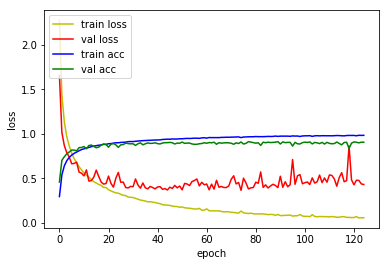

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.4336 - acc: 0.8829
Loss: 0.4336039381389925 Accuracy: 0.882866

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5425 - acc: 0.2341
Epoch 00001: val_loss improved from inf to 1.81241, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_DO_BN_7_conv_checkpoint/001-1.8124.hdf5
36805/36805 [==============================] - 189s 5ms/sample - loss: 2.5424 - acc: 0.2342 - val_loss: 1.8124 - val_acc: 0.4172
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6286 - acc: 0.4703
Epoch 00002: val_loss improved from 1.81241 to 1.18490, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_DO_BN_7_conv_checkpoint/002-1.1849.hdf5
36805/36805 [==============================] - 184s 5ms/sample - loss: 1.6285 - acc: 0.4703 - val_loss: 1.1849 - val_acc: 0.6436
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 0.2559 - acc: 0.9215
Epoch 00024: val_loss improved from 0.28195 to 0.26524, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_DO_BN_7_conv_checkpoint/024-0.2652.hdf5
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.2559 - acc: 0.9215 - val_loss: 0.2652 - val_acc: 0.9324
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2492 - acc: 0.9243
Epoch 00025: val_loss did not improve from 0.26524
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.2492 - acc: 0.9243 - val_loss: 0.2813 - val_acc: 0.9255
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2360 - acc: 0.9269
Epoch 00026: val_loss did not improve from 0.26524
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.2360 - acc: 0.9269 - val_loss: 0.2679 - val_acc: 0.9294
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.227

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1042 - acc: 0.9668
Epoch 00053: val_loss did not improve from 0.22880
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.1042 - acc: 0.9667 - val_loss: 0.3132 - val_acc: 0.9210
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1108 - acc: 0.9642
Epoch 00054: val_loss did not improve from 0.22880
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.1109 - acc: 0.9642 - val_loss: 0.2341 - val_acc: 0.9387
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1033 - acc: 0.9683
Epoch 00055: val_loss did not improve from 0.22880
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.1034 - acc: 0.9683 - val_loss: 0.3110 - val_acc: 0.9175
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1021 - acc: 0.9675
Epoch 00056: val_loss did not improve from 0.22880
36805/36805 [========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0665 - acc: 0.9788
Epoch 00083: val_loss did not improve from 0.22880
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.0665 - acc: 0.9788 - val_loss: 0.2993 - val_acc: 0.9364
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0576 - acc: 0.9821
Epoch 00084: val_loss did not improve from 0.22880
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.0577 - acc: 0.9820 - val_loss: 0.3160 - val_acc: 0.9317
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0640 - acc: 0.9792
Epoch 00085: val_loss did not improve from 0.22880
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.0640 - acc: 0.9792 - val_loss: 0.2483 - val_acc: 0.9418
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0568 - acc: 0.9820
Epoch 00086: val_loss did not improve from 0.22880
36805/36805 [========

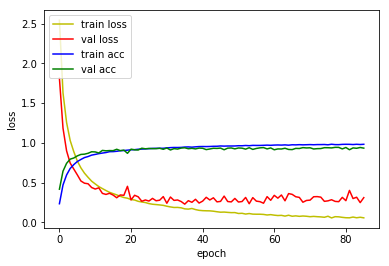

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.2752 - acc: 0.9202
Loss: 0.27517747267508186 Accuracy: 0.9202492

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5533 - acc: 0.2488
Epoch 00001: val_loss improved from inf to 1.78258, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_DO_BN_8_conv_checkpoint/001-1.7826.hdf5
36805/36805 [==============================] - 194s 5ms/sample - loss: 2.5532 - acc: 0.2488 - val_loss: 1.7826 - val_acc: 0.4948
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6142 - acc: 0.4838
Epoch 00002: val_loss improved from 1.78258 to 0.99419, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_DO_BN_8_conv_checkpoint/002-0.9942.hdf5
36805/36805 [==============================] - 185s 5ms/sample - loss: 1.6142 - acc: 0.4837 - val_loss: 0.9942 - val_acc: 0.7098
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1837 - acc: 0.9429
Epoch 00024: val_loss did not improve from 0.17202
36805/36805 [==============================] - 185s 5ms/sample - loss: 0.1837 - acc: 0.9429 - val_loss: 0.1749 - val_acc: 0.9478
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1782 - acc: 0.9453
Epoch 00025: val_loss did not improve from 0.17202
36805/36805 [==============================] - 185s 5ms/sample - loss: 0.1782 - acc: 0.9453 - val_loss: 0.1853 - val_acc: 0.9457
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1706 - acc: 0.9485
Epoch 00026: val_loss did not improve from 0.17202
36805/36805 [==============================] - 185s 5ms/sample - loss: 0.1707 - acc: 0.9484 - val_loss: 0.1847 - val_acc: 0.9439
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1670 - acc: 0.9489
Epoch 00027: val_loss did not improve from 0.17202
36805/36805 [========

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0747 - acc: 0.9764
Epoch 00053: val_loss did not improve from 0.14243
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.0746 - acc: 0.9764 - val_loss: 0.1478 - val_acc: 0.9599
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0652 - acc: 0.9800
Epoch 00054: val_loss did not improve from 0.14243
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.0651 - acc: 0.9800 - val_loss: 0.1438 - val_acc: 0.9592
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0658 - acc: 0.9802
Epoch 00055: val_loss did not improve from 0.14243
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.0658 - acc: 0.9802 - val_loss: 0.1665 - val_acc: 0.9576
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0646 - acc: 0.9801
Epoch 00056: val_loss did not improve from 0.14243
36805/36805 [========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0400 - acc: 0.9870
Epoch 00083: val_loss did not improve from 0.14243
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.0400 - acc: 0.9870 - val_loss: 0.1794 - val_acc: 0.9578
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0309 - acc: 0.9906
Epoch 00084: val_loss did not improve from 0.14243
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.0310 - acc: 0.9906 - val_loss: 0.1502 - val_acc: 0.9627
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0341 - acc: 0.9900
Epoch 00085: val_loss did not improve from 0.14243
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.0341 - acc: 0.9900 - val_loss: 0.1730 - val_acc: 0.9583
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0324 - acc: 0.9908
Epoch 00086: val_loss did not improve from 0.14243
36805/36805 [========

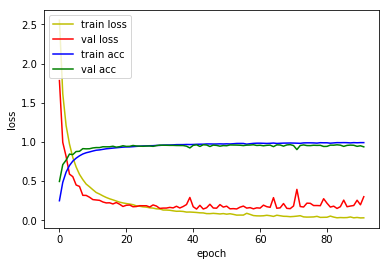

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.1976 - acc: 0.9450
Loss: 0.19761540082632442 Accuracy: 0.94496363

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5867 - acc: 0.2312
Epoch 00001: val_loss improved from inf to 1.91536, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_DO_BN_9_conv_checkpoint/001-1.9154.hdf5
36805/36805 [==============================] - 198s 5ms/sample - loss: 2.5867 - acc: 0.2312 - val_loss: 1.9154 - val_acc: 0.4782
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6852 - acc: 0.4652
Epoch 00002: val_loss improved from 1.91536 to 1.01362, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_DO_BN_9_conv_checkpoint/002-1.0136.hdf5
36805/36805 [==============================] - 185s 5ms/sample - loss: 1.6853 - acc: 0.4652 - val_loss: 1.0136 - val_acc: 0.7258
Epoch 3/500
36800/36805 [============================>.] - ETA: 0

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2294 - acc: 0.9324
Epoch 00024: val_loss did not improve from 0.15926
36805/36805 [==============================] - 185s 5ms/sample - loss: 0.2295 - acc: 0.9324 - val_loss: 0.1690 - val_acc: 0.9495
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2292 - acc: 0.9313
Epoch 00025: val_loss did not improve from 0.15926
36805/36805 [==============================] - 185s 5ms/sample - loss: 0.2292 - acc: 0.9313 - val_loss: 0.1597 - val_acc: 0.9550
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2134 - acc: 0.9358
Epoch 00026: val_loss improved from 0.15926 to 0.14628, saving model to model/checkpoint/1D_CNN_custom_2_ch_128_DO_BN_9_conv_checkpoint/026-0.1463.hdf5
36805/36805 [==============================] - 185s 5ms/sample - loss: 0.2136 - acc: 0.9358 - val_loss: 0.1463 - val_acc: 0.9576
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1002 - acc: 0.9698
Epoch 00052: val_loss did not improve from 0.12221
36805/36805 [==============================] - 185s 5ms/sample - loss: 0.1002 - acc: 0.9698 - val_loss: 0.1228 - val_acc: 0.9665
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0951 - acc: 0.9716
Epoch 00053: val_loss did not improve from 0.12221
36805/36805 [==============================] - 185s 5ms/sample - loss: 0.0951 - acc: 0.9716 - val_loss: 0.1555 - val_acc: 0.9576
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0913 - acc: 0.9716
Epoch 00054: val_loss did not improve from 0.12221
36805/36805 [==============================] - 186s 5ms/sample - loss: 0.0913 - acc: 0.9716 - val_loss: 0.1394 - val_acc: 0.9585
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0862 - acc: 0.9734
Epoch 00055: val_loss did not improve from 0.12221
36805/36805 [========

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0611 - acc: 0.9810
Epoch 00082: val_loss did not improve from 0.12221
36805/36805 [==============================] - 185s 5ms/sample - loss: 0.0611 - acc: 0.9810 - val_loss: 0.1500 - val_acc: 0.9618
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0520 - acc: 0.9843
Epoch 00083: val_loss did not improve from 0.12221
36805/36805 [==============================] - 186s 5ms/sample - loss: 0.0522 - acc: 0.9843 - val_loss: 0.1557 - val_acc: 0.9623
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0625 - acc: 0.9804
Epoch 00084: val_loss did not improve from 0.12221
36805/36805 [==============================] - 185s 5ms/sample - loss: 0.0627 - acc: 0.9804 - val_loss: 0.1551 - val_acc: 0.9625
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0635 - acc: 0.9801
Epoch 00085: val_loss did not improve from 0.12221
36805/36805 [========

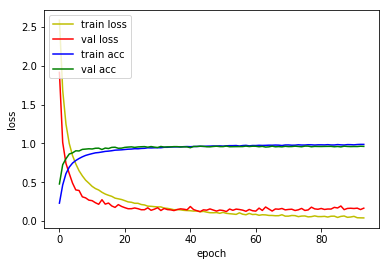

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.1758 - acc: 0.9458
Loss: 0.17580016524466152 Accuracy: 0.9457944



In [11]:
for i in range(6, 10):
    base = '1D_CNN_custom_2_ch_128_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [12]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_2_ch_128_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(6, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_2_ch_128_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_46 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (Non

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2752 - acc: 0.9202
Loss: 0.27517747267508186 Accuracy: 0.9202492

1D_CNN_custom_2_ch_128_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_58 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_58 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_58 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_59 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_59 (Activation)   (N

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.1758 - acc: 0.9458
Loss: 0.17580016524466152 Accuracy: 0.9457944


In [13]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(6, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_2_ch_128_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_46 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (Non

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.3732 - acc: 0.9157
Loss: 0.3731967528815829 Accuracy: 0.91568017

1D_CNN_custom_2_ch_128_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_58 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_58 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_58 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_59 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_59 (Activation)   (N

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2225 - acc: 0.9481
Loss: 0.22254017482150001 Accuracy: 0.94807893
